## Model_Kanal_D
## Table of Contents:
* [0. Importing dependencies](#dependencies)
* [1. Setting up of the dataset](#1.0)
    * [1.1 Importing of the dataset](#1.1)
    * [1.2 Preparing the dataset](#1.2)
* [2. Model applicability testing](#2.0)
   


# 0. Importing dependencies  <a class="anchor" id="dependencies"></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt
import joblib

# 1. Setting up of the dataset <a class="anchor" id="1.0"></a>

## 1.1 Importing of the dataset <a class="anchor" id="1.1"></a>

In [2]:
# Load the final dataframe
file_path = 'C:/Users/support/Desktop/Yılın Yang/df_final_Kanal_D.csv'
df_final = pd.read_csv(file_path)

print(df_final.columns)

Index(['trend_vc', 'weekly_vc', 'trend_i', 'weekly_i', 'trend_ud', 'weekly_ud',
       'videoConsumption', 'impression'],
      dtype='object')


## 1.2 Preparing the dataset <a class="anchor" id="1.2"></a>

In [13]:
# Define input features and target outputs
prophet_features = ['weekly_vc', 'weekly_i', 'weekly_ud']
targets = ['videoConsumption', 'impression']

all_features = prophet_features + targets  # Include both Prophet features and original data
# Create test_data

test_data = df_final[all_features].values

# 2. Model applicability testing <a class="anchor" id="2.0"></a>

In [4]:
# Load the best models
best_rf_model = joblib.load('C:/Users/support/Desktop/Yılın Yang/Best_RF_Model.pkl')
best_lgbm_model = joblib.load('C:/Users/support/Desktop/Yılın Yang/Best_LightGBM_Model.pkl')
best_xgb_model = joblib.load('C:/Users/support/Desktop/Yılın Yang/Best_XGBoost_Model.pkl')

In [5]:
# Function for rolling window forecast
def rolling_window_forecast(data, window_size, forecast_horizon, model):
    predictions_vc, predictions_i = [], []
    true_values_vc, true_values_i = [], []

    for start in range(0, len(data) - window_size - forecast_horizon, forecast_horizon):
        end = start + window_size
        X_train = data[start:end]
        y_train_vc = data[start:end, -2]
        y_train_i = data[start:end, -1]

        X_test = data[end:end + forecast_horizon]
        y_test_vc = data[end:end + forecast_horizon, -2]
        y_test_i = data[end:end + forecast_horizon, -1]

        y_train = np.vstack((y_train_vc, y_train_i)).T
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)

        predictions_vc.extend(y_pred[:, 0])
        predictions_i.extend(y_pred[:, 1])
        true_values_vc.extend(y_test_vc)
        true_values_i.extend(y_test_i)

    return predictions_vc, predictions_i, true_values_vc, true_values_i


In [6]:
# Final evaluation using rolling window on test set
forecast_horizon = 1440  # fixed forecast horizon
window_size = 1440 * 7  # best window size

In [7]:
# Function to calculate Percentage RMSE
def calculate_percentage_rmse(rmse, true_values):
    mean_actual = np.mean(true_values)
    return (rmse / mean_actual) * 100

In [8]:
def evaluate_model_rolling_window(model, data, window_size, forecast_horizon):
    predictions_vc, predictions_i, true_values_vc, true_values_i = rolling_window_forecast(data, window_size, forecast_horizon, model)
    mse_vc = mean_squared_error(true_values_vc, predictions_vc)
    rmse_vc = sqrt(mse_vc)
    mse_i = mean_squared_error(true_values_i, predictions_i)
    rmse_i = sqrt(mse_i)
    pr_rmse_vc = calculate_percentage_rmse(rmse_vc, true_values_vc)
    pr_rmse_i = calculate_percentage_rmse(rmse_i, true_values_i)
    return {
        "predictions_vc": predictions_vc, "predictions_i": predictions_i,
        "true_values_vc": true_values_vc, "true_values_i": true_values_i,
        "mse_vc": mse_vc, "rmse_vc": rmse_vc,
        "mse_i": mse_i, "rmse_i": rmse_i,
        "pr_rmse_vc": pr_rmse_vc, "pr_rmse_i": pr_rmse_i
    }

In [9]:
# Plotting Predictions as Time Series and Scatter Plot
def plot_time_series(true_values, predictions, title):
    plt.figure(figsize=(10, 6))
    plt.plot(true_values, label='Actual')
    plt.plot(predictions, label='Predicted', linestyle='--')
    plt.title(title)
    plt.xlabel('Time Index')
    plt.ylabel('Value')
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_predictions(true_values, predictions, title):
    true_values = np.array(true_values)  
    predictions = np.array(predictions) 
    plt.figure(figsize=(8, 6))
    plt.scatter(true_values, predictions, alpha=0.3)
    plt.plot([true_values.min(), true_values.max()], [true_values.min(), true_values.max()], 'k--', lw=3)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(title)
    plt.tight_layout()
    plt.show()


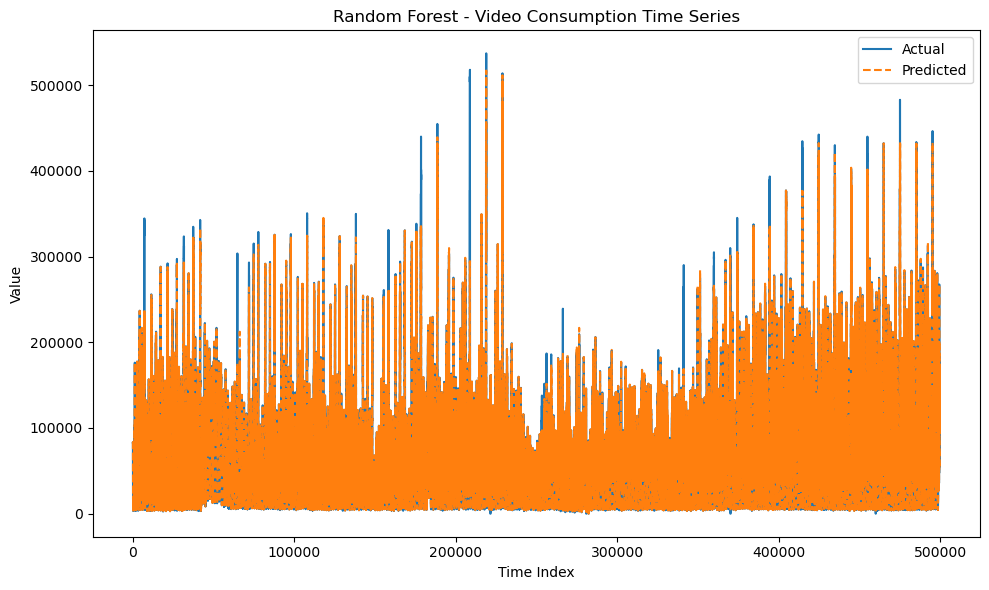

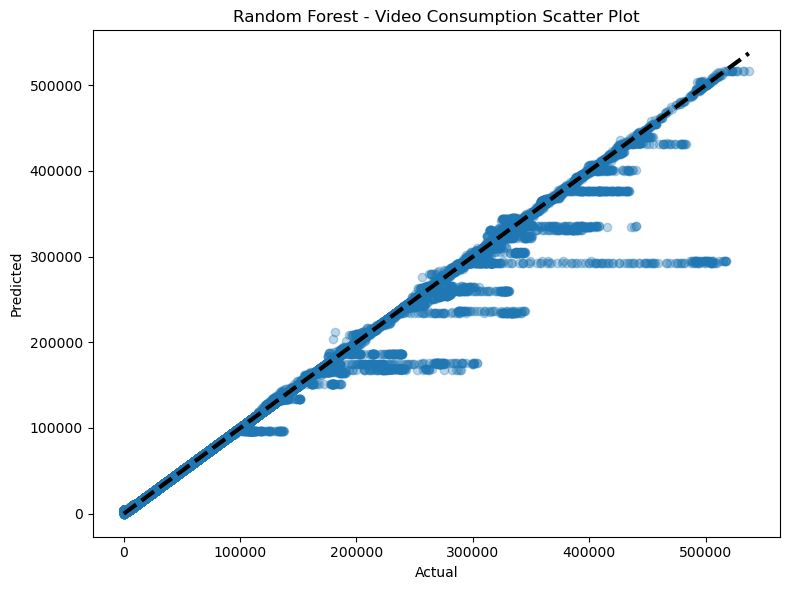

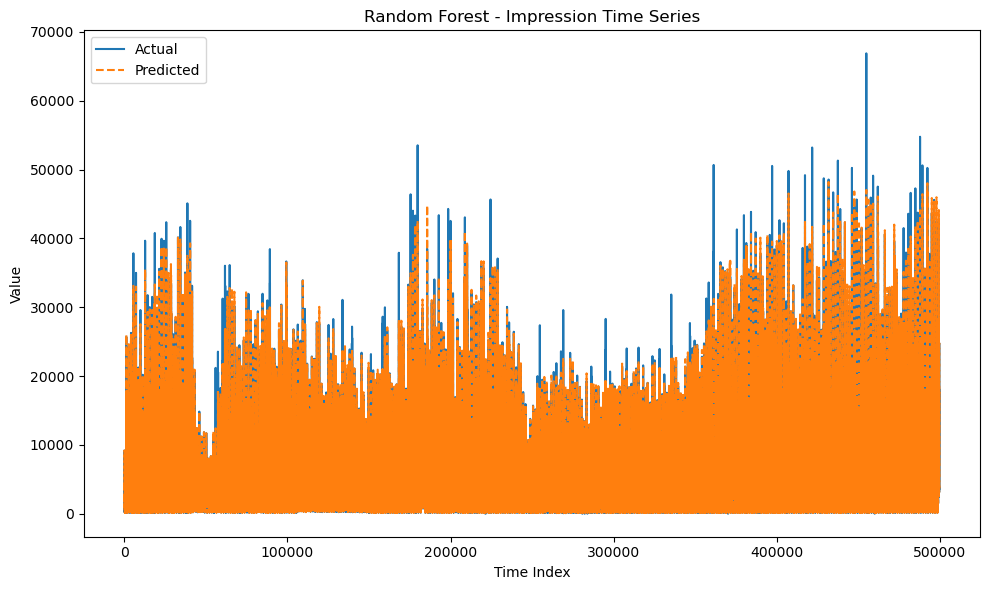

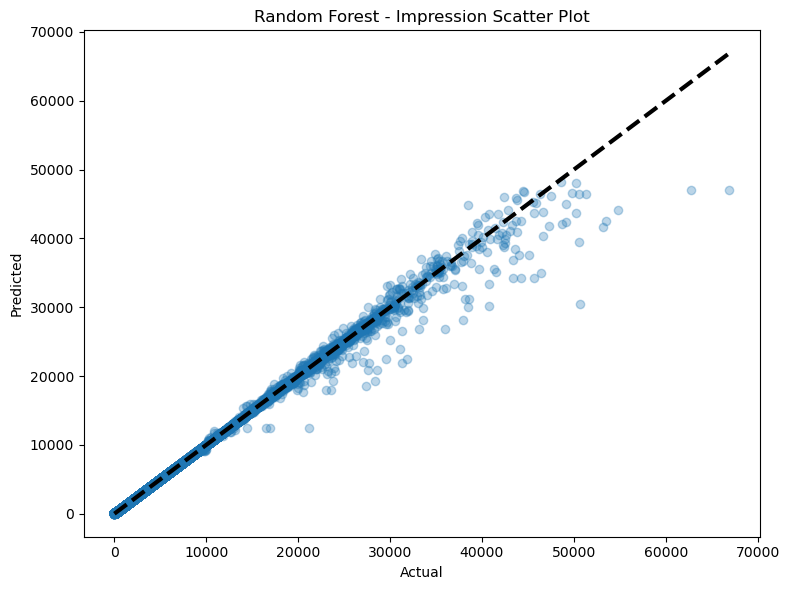

Random Forest - Video Consumption MSE: 13955967.635, RMSE: 3735.769, PRMSE: 6.538%
Random Forest - Impression MSE: 9761.789, RMSE: 98.802, PRMSE: 3.076%


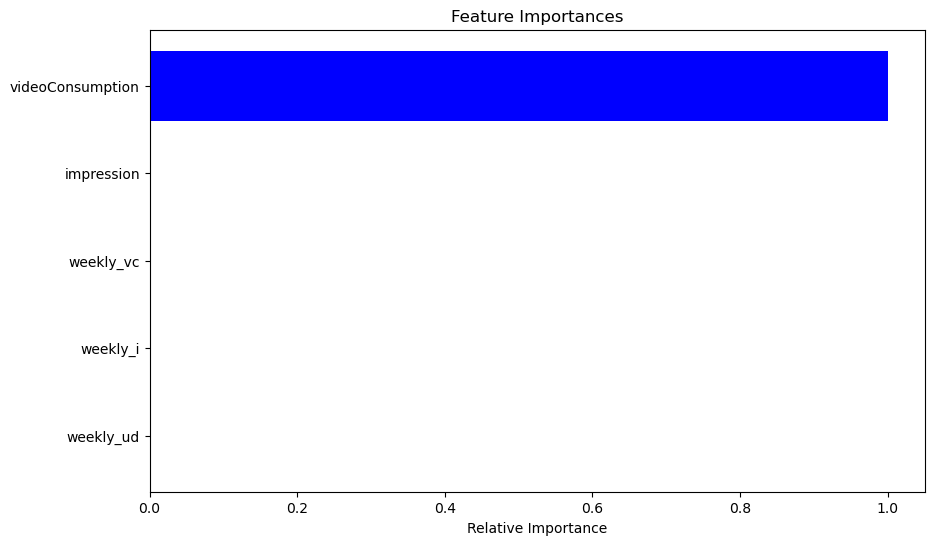

Feature Importances: [('weekly_vc', 4.360382988046168e-06), ('weekly_i', 1.6306489471363313e-06), ('weekly_ud', 1.4927628077399498e-06), ('videoConsumption', 0.9999848328385978), ('impression', 7.683366659218582e-06)]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000727 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 10080, number of used features: 5
[LightGBM] [Info] Start training from score 51102.901389
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000288 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 10080, number of used features: 5
[LightGBM] [Info] Start training from score 3372.845933
[LightGBM] [Info] Auto-choosi

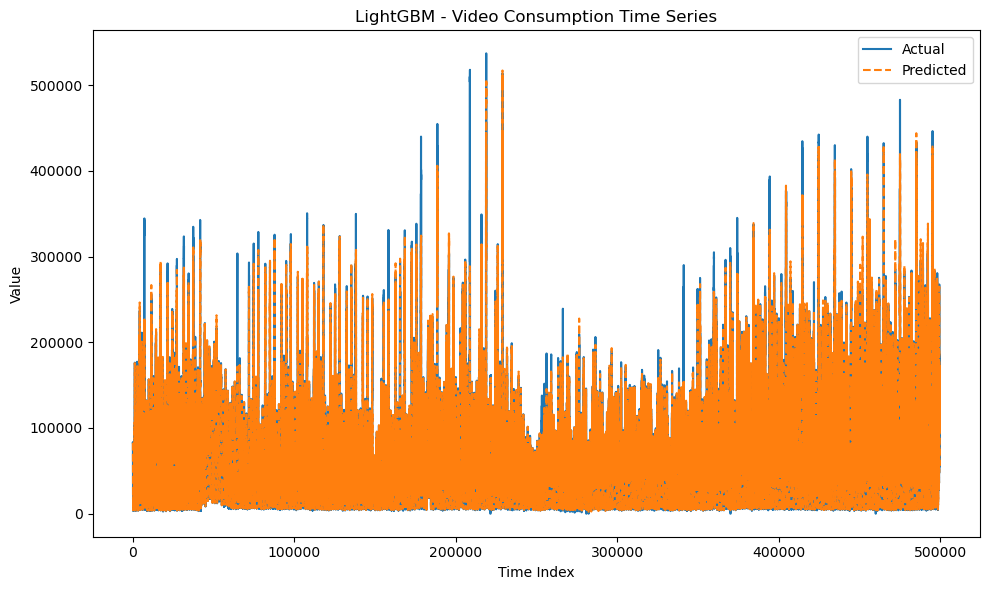

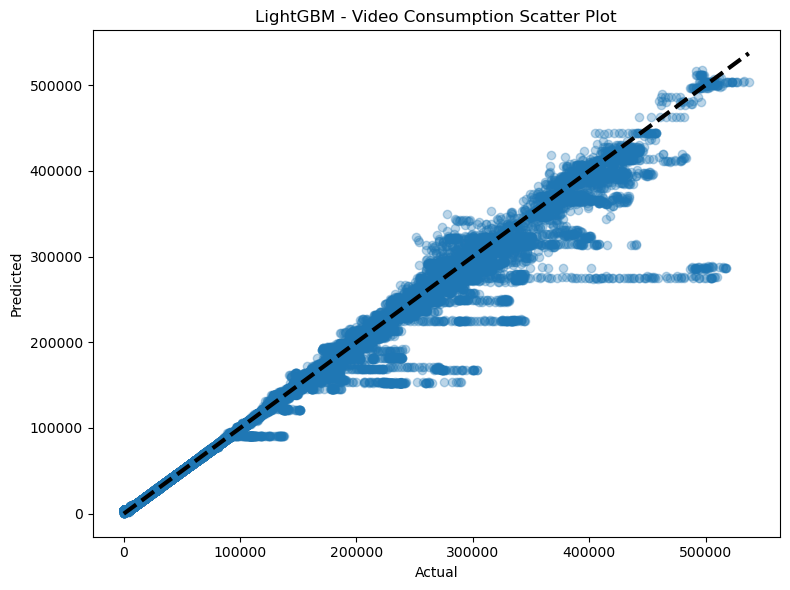

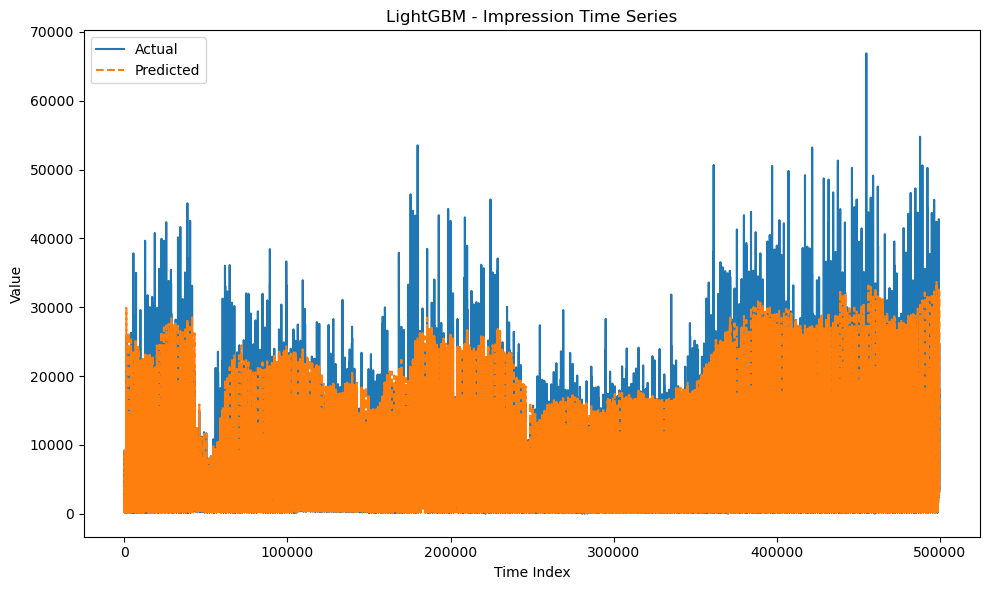

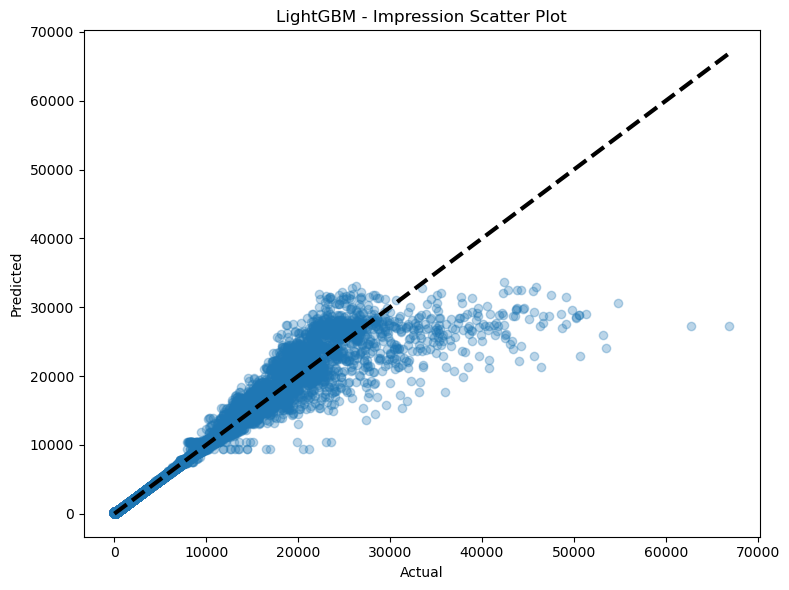

LightGBM - Video Consumption MSE: 21034728.750, RMSE: 4586.363, PRMSE: 8.027%
LightGBM - Impression MSE: 115823.053, RMSE: 340.328, PRMSE: 10.597%


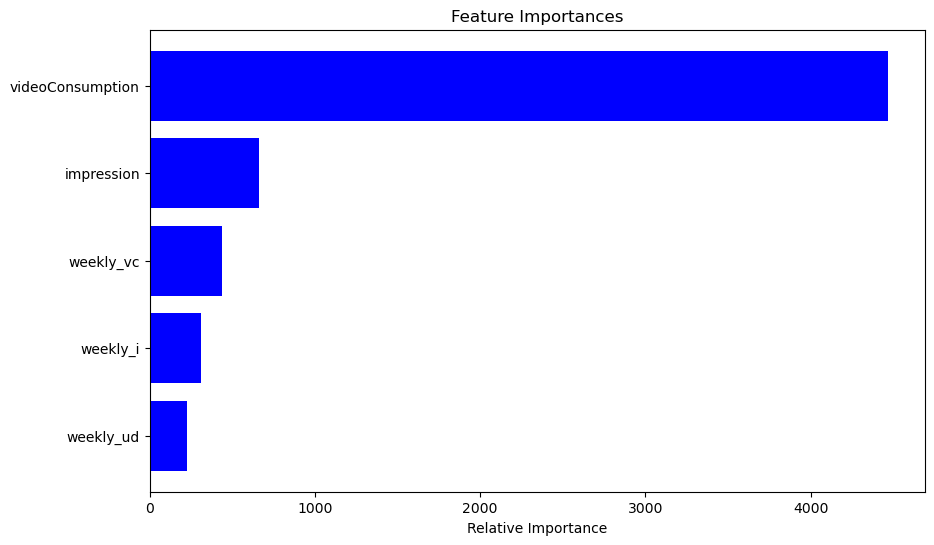

Feature Importances: [('weekly_vc', 437), ('weekly_i', 310), ('weekly_ud', 225), ('videoConsumption', 4466), ('impression', 662)]


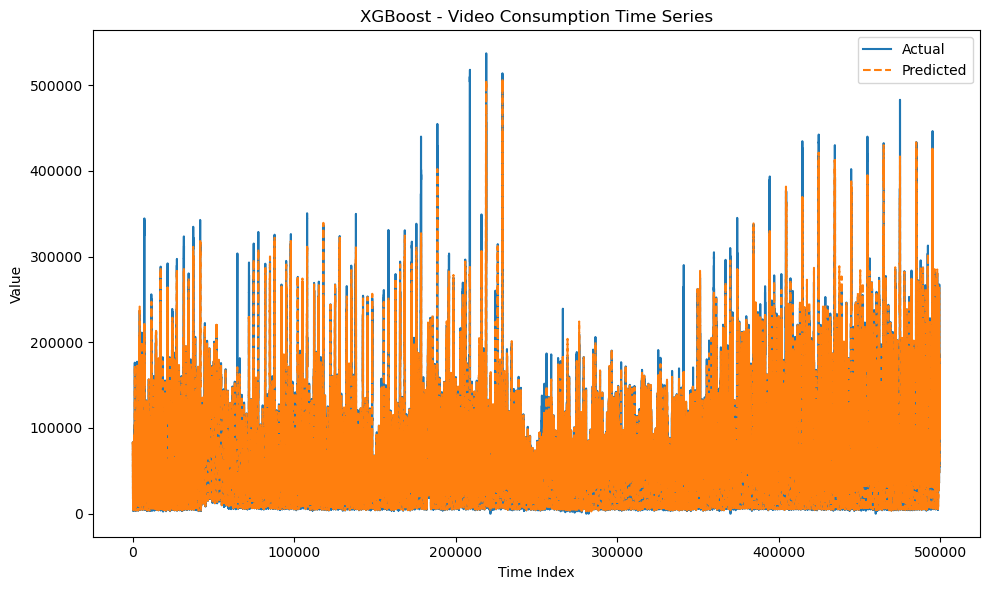

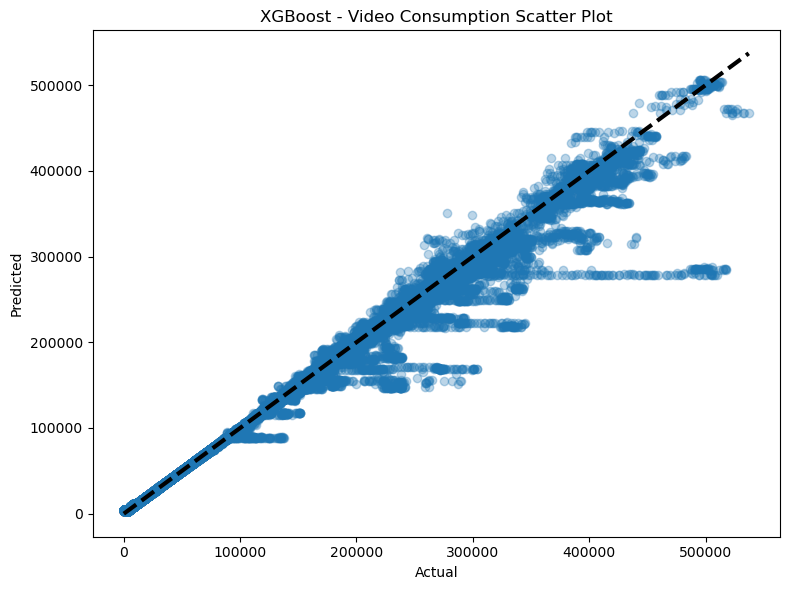

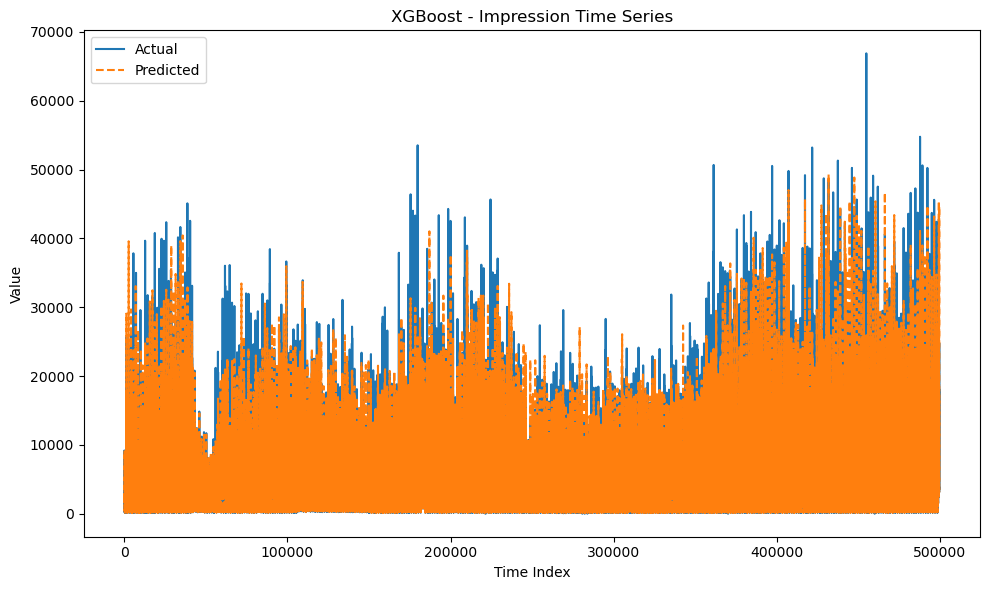

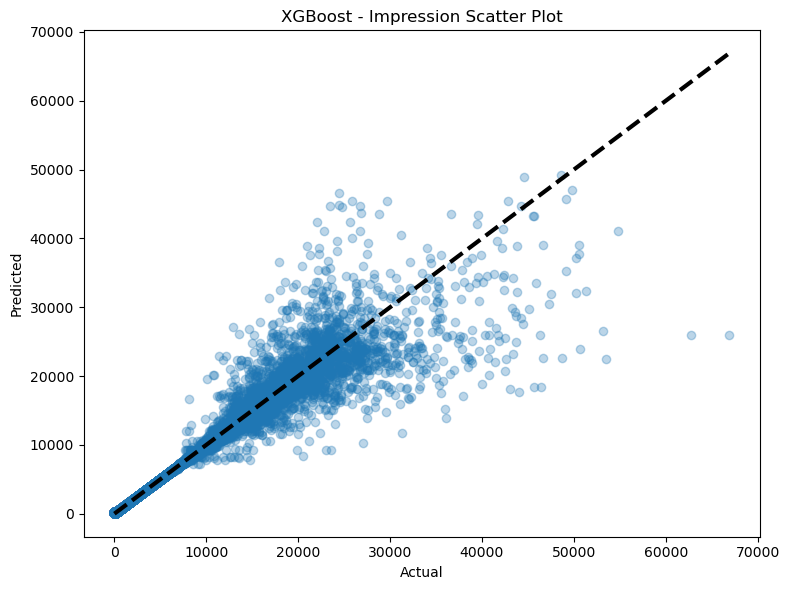

XGBoost - Video Consumption MSE: 22283342.933, RMSE: 4720.524, PRMSE: 8.262%
XGBoost - Impression MSE: 152085.554, RMSE: 389.981, PRMSE: 12.143%


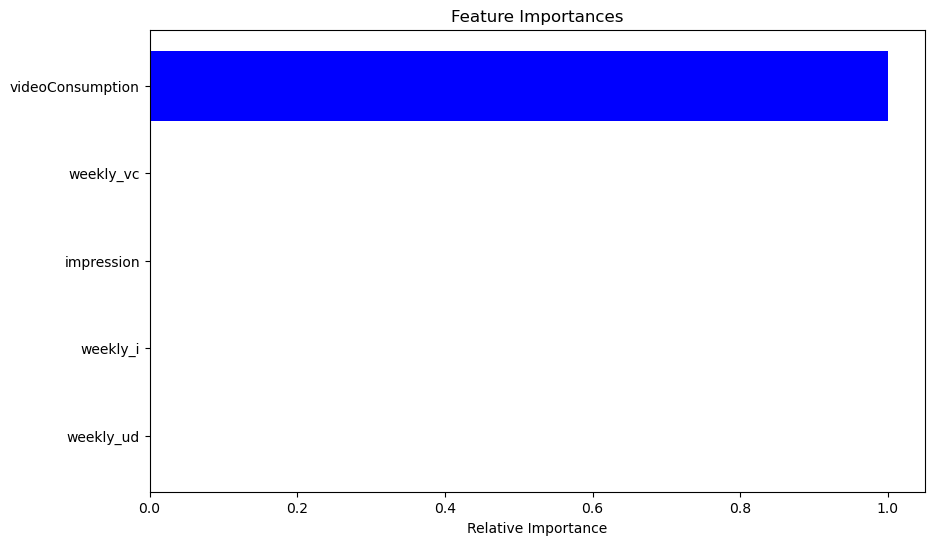

Feature Importances: [('weekly_vc', 0.00020253845), ('weekly_i', 3.7085207e-05), ('weekly_ud', 3.5519275e-05), ('videoConsumption', 0.9996633), ('impression', 6.1591476e-05)]


In [16]:
def process_model(model, test_data, window_size, forecast_horizon, model_name, all_features):
    results = evaluate_model_rolling_window(model, test_data, window_size, forecast_horizon)
    plot_time_series(results["true_values_vc"], results["predictions_vc"], f'{model_name} - Video Consumption Time Series')
    plot_predictions(results["true_values_vc"], results["predictions_vc"], f'{model_name} - Video Consumption Scatter Plot')
    plot_time_series(results["true_values_i"], results["predictions_i"], f'{model_name} - Impression Time Series')
    plot_predictions(results["true_values_i"], results["predictions_i"], f'{model_name} - Impression Scatter Plot')
    
    print(f"{model_name} - Video Consumption MSE: {results['mse_vc']:.3f}, RMSE: {results['rmse_vc']:.3f}, PRMSE: {results['pr_rmse_vc']:.3f}%")
    print(f"{model_name} - Impression MSE: {results['mse_i']:.3f}, RMSE: {results['rmse_i']:.3f}, PRMSE: {results['pr_rmse_i']:.3f}%")
    
    if hasattr(model, 'feature_importances_'):
        feature_importances = model.feature_importances_
        plot_feature_importance(model, all_features)
        print("Feature Importances:", list(zip(all_features, feature_importances)))
    elif hasattr(model.estimators_[0], 'feature_importances_'):  # For MultiOutputRegressor
        feature_importances = model.estimators_[0].feature_importances_
        plot_feature_importance(model.estimators_[0], all_features)
        print("Feature Importances:", list(zip(all_features, feature_importances)))

def plot_feature_importance(model, feature_names):
    plt.figure(figsize=(10, 6))
    importances = model.feature_importances_
    indices = np.argsort(importances)
    plt.title('Feature Importances')
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()

process_model(best_rf_model, test_data, window_size, forecast_horizon, "Random Forest", all_features)
process_model(best_lgbm_model, test_data, window_size, forecast_horizon, "LightGBM", all_features)
process_model(best_xgb_model, test_data, window_size, forecast_horizon, "XGBoost", all_features)